# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

import time

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/datasets/autos.csv')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [ ]:
for column in df.columns:
        print('Уникальные значения столбца', column)
        print(df[column].unique())

Уникальные значения столбца DateCrawled
['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Уникальные значения столбца Price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца RegistrationYear
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290

Что нужно поправить в исходных данных:
* Удалить лишние колонки, такие как DateCrawled, 'DateCreated, NumberOfPictures, PostalCode, LastSeen
* Проверить коректность значений целевого признака (Price) и при необходимости обработать значения
* В столбце VehicleType необходимо восстановить значения вместо NaN по популярному типу из столбца Brand
* Заменить значения NaN столбца FuelType
* Скорректировать значения в столбце RegistrationYear, поскольку в исходных данных много выбросов
* Убрать пропущенные значения в стобце Gearbox
* Удалить выбросы в столбце Power
* В стобце Model заменить значения NaN на unknown
* В стобце NotRepaired заченить значения NaN на no

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корректно, первичный осмотр проведен.
</div>

### Обработка данных

Удаляю лишние колонки

In [ ]:
filtred_df = df[['VehicleType', 
                         'Gearbox', 
                         'Power',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'NotRepaired',
                         'RegistrationYear',
                         'Model',
                         'Price']]

Обработка данных в целевом признаке

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

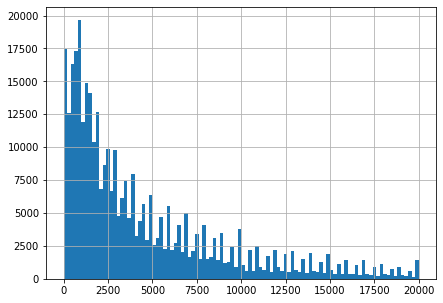

In [ ]:
filtred_df['Price'].hist(bins=100, figsize=(7,5))
filtred_df['Price'].describe()

Уберу из исходного датафрейма данные о машинах с ценой 0

In [ ]:
filtred_df = filtred_df.query('Price > 0')

Обработка стобца VehicleType

In [ ]:
display(filtred_df['VehicleType'].value_counts())
filtred_df['VehicleType'].isna().sum()

sedan          89405
small          78018
wagon          63701
bus            28345
convertible    19865
coupe          15636
suv            11791
other           3086
Name: VehicleType, dtype: int64

33750

В значительной части исходных данных в признаке VehicleType стоит значение NaN. 

Заменю NaN в соотвествии с популярным типом кузова для каждого бренда

In [ ]:
vehicle_type = filtred_df.pivot_table(index=['VehicleType'], columns=['Brand'], values=['Price'], aggfunc=['count'])['count']['Price']
display(vehicle_type)

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,6.0,156.0,415.0,1252.0,50.0,27.0,34.0,818.0,...,610.0,231.0,1.0,187.0,17.0,27.0,446.0,NaN,9388.0,NaN
convertible,177.0,1612.0,3199.0,17.0,228.0,112.0,NaN,1.0,17.0,506.0,...,NaN,4.0,1126.0,322.0,1.0,35.0,63.0,36.0,2887.0,75.0
coupe,226.0,1464.0,3683.0,89.0,47.0,148.0,NaN,8.0,NaN,168.0,...,84.0,10.0,338.0,222.0,8.0,7.0,222.0,3.0,1725.0,67.0
other,14.0,107.0,224.0,43.0,9.0,114.0,6.0,5.0,10.0,178.0,...,62.0,26.0,9.0,217.0,6.0,14.0,19.0,5.0,722.0,5.0
sedan,912.0,10677.0,17224.0,223.0,279.0,693.0,100.0,105.0,47.0,877.0,...,1738.0,904.0,28.0,465.0,164.0,178.0,887.0,201.0,19299.0,635.0
small,235.0,1538.0,437.0,580.0,12.0,1570.0,221.0,265.0,512.0,5192.0,...,3060.0,1115.0,3232.0,240.0,117.0,967.0,1580.0,54.0,17979.0,7.0
suv,NaN,177.0,805.0,377.0,23.0,36.0,214.0,1.0,46.0,24.0,...,4.0,173.0,NaN,422.0,59.0,743.0,439.0,1.0,1308.0,219.0
wagon,451.0,10827.0,7763.0,105.0,241.0,617.0,251.0,46.0,16.0,444.0,...,387.0,2684.0,9.0,123.0,292.0,87.0,568.0,71.0,12374.0,1934.0


Заполню словарь брендов и популярных типов машин и заполню пропуски по столбцу VehicleType

In [ ]:
filtred_df.fillna({'VehicleType':0},inplace=True)

def fillna_by_brand(row, row_number, vehicle_type):
    brand = row[5]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type[brand].idxmax()
    return fill_value

filtred_df['VehicleType'] = filtred_df.apply(fillna_by_brand, args=[0, vehicle_type], axis=1)
display(filtred_df['VehicleType'].isna().sum())
filtred_df['VehicleType'].value_counts()

0

sedan          105190
small           92761
wagon           66450
bus             28459
convertible     19933
coupe           15636
suv             12082
other            3086
Name: VehicleType, dtype: int64

Аналогично заполню пропуски в FuelType

In [ ]:
filtred_df['FuelType'].value_counts()
fuel_type = filtred_df.pivot_table(index=['FuelType'], columns=['Brand'], values=['Price'], aggfunc=['count'])['count']['Price']
display(fuel_type)

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,10.0,4.0,NaN,8.0,2.0,NaN,NaN,68.0,...,3.0,6.0,3.0,7.0,2.0,NaN,NaN,NaN,186.0,20.0
electric,NaN,2.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,4.0,...,NaN,NaN,7.0,21.0,NaN,NaN,NaN,NaN,5.0,NaN
gasoline,598.0,12213.0,11966.0,236.0,377.0,1594.0,206.0,1.0,4.0,1492.0,...,1676.0,1912.0,868.0,441.0,41.0,229.0,983.0,1.0,25238.0,1051.0
hybrid,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,1.0,20.0,NaN,NaN,126.0,1.0,5.0,NaN
lpg,37.0,451.0,750.0,177.0,93.0,70.0,53.0,23.0,6.0,68.0,...,63.0,52.0,3.0,121.0,30.0,24.0,25.0,NaN,540.0,108.0
other,NaN,4.0,8.0,1.0,NaN,3.0,NaN,1.0,NaN,4.0,...,NaN,NaN,1.0,30.0,1.0,1.0,1.0,37.0,23.0,3.0
petrol,1406.0,13899.0,20478.0,1152.0,789.0,2965.0,573.0,443.0,673.0,6753.0,...,4420.0,3171.0,3952.0,1481.0,581.0,1825.0,3147.0,281.0,41749.0,1740.0


In [ ]:
filtred_df.fillna({'FuelType':0},inplace=True)

filtred_df['FuelType'] = filtred_df.apply(fillna_by_brand, args=[4, fuel_type], axis=1)
display(filtred_df['FuelType'].isna().sum())
filtred_df['FuelType'].value_counts()

0

petrol      240200
gasoline     97192
lpg           5166
cng            554
hybrid         227
other          170
electric        88
Name: FuelType, dtype: int64

В столбце RegistrationYear удалю значения несуществующих годов(или слишком поздних годов, тут уже надо обращаться не в приложение, а к коллекционерам)

In [ ]:
filtred_df = filtred_df.query('1940 < RegistrationYear < 2021')

count    343352.000000
mean       2003.204376
std           7.227481
min        1941.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

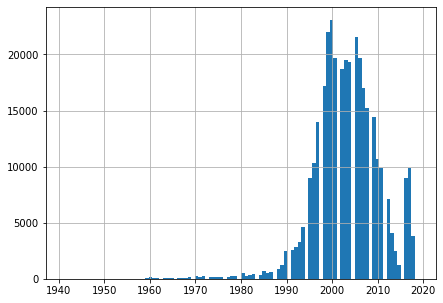

In [ ]:
filtred_df['RegistrationYear'].hist(bins=100, figsize=(7,5))
filtred_df['RegistrationYear'].describe()

В столбцах Gearbox, NotRepaired, Model заменю пропущенные значения

In [ ]:
filtred_df.fillna({'Gearbox':'manual', 'NotRepaired':'no', 'Model':'unknown'}, inplace=True)

Проверю столбец Power на выбросы

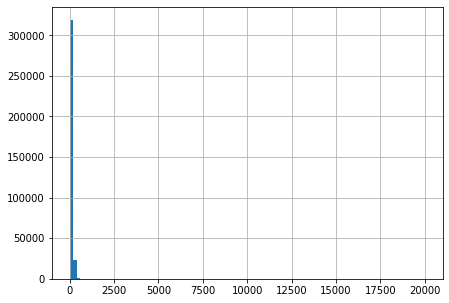

In [ ]:
filtred_df['Power'].hist(bins=100, figsize=(7,5))

Наблюдаются выбросы. Сокращу диапазон значений

count    343072.000000
mean        107.668178
std          63.619308
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max        1000.000000
Name: Power, dtype: float64

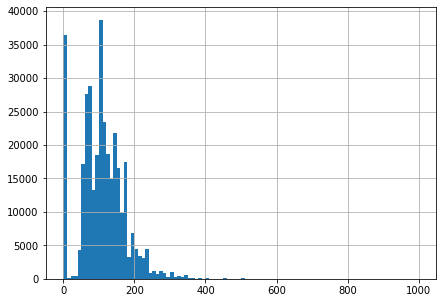

In [ ]:
filtred_df = filtred_df.query('Power < 1001')
filtred_df['Power'].hist(bins=100, figsize=(7,5))
filtred_df['Power'].describe()

У многих машин указаная мощность равна  нулю, удалю строки с таокй мощностью

count    306529.000000
mean        120.201945
std          53.369127
min          11.000000
25%          75.000000
50%         110.000000
75%         150.000000
max         500.000000
Name: Power, dtype: float64

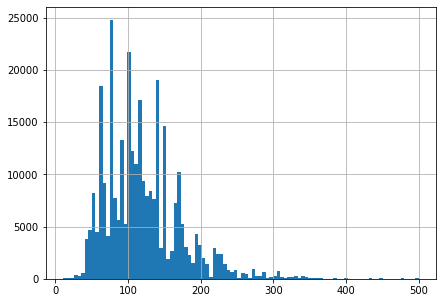

In [ ]:
filtred_df = filtred_df.query('10 < Power < 501')
filtred_df['Power'].hist(bins=100, figsize=(7,5))
filtred_df['Power'].describe()

С пропущенными значениями покончено

In [ ]:
filtred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306529 entries, 1 to 354368
Data columns (total 10 columns):
VehicleType         306529 non-null object
Gearbox             306529 non-null object
Power               306529 non-null int64
Kilometer           306529 non-null int64
FuelType            306529 non-null object
Brand               306529 non-null object
NotRepaired         306529 non-null object
RegistrationYear    306529 non-null int64
Model               306529 non-null object
Price               306529 non-null int64
dtypes: int64(4), object(6)
memory usage: 25.7+ MB


Теперь надо изменить тип данных, чтобы все признаки были с типом int64

In [ ]:
filtred_df['IsManualGearbox'] = 0
filtred_df.loc[filtred_df['Gearbox'] == 'manual', 'IsManualGearbox'] = 1

In [ ]:
filtred_df['IsNotRepaired'] = 0
filtred_df.loc[filtred_df['NotRepaired'] == 'yes', 'IsNotRepaired'] = 1

In [ ]:
filtred_df.drop(['NotRepaired','Gearbox'], inplace=True, axis=1)

In [ ]:
filtred_df['IsNotRepaired'] = pd.to_numeric(filtred_df['IsNotRepaired'], downcast='integer')
filtred_df['IsManualGearbox'] = pd.to_numeric(filtred_df['IsManualGearbox'], downcast='integer')
filtred_df['RegistrationYear'] = pd.to_numeric(filtred_df['RegistrationYear'], downcast='integer')
filtred_df['Power'] = pd.to_numeric(filtred_df['Power'], downcast='integer')
filtred_df['Kilometer'] = pd.to_numeric(filtred_df['Kilometer'], downcast='integer')
filtred_df['Price'] = pd.to_numeric(filtred_df['Price'], downcast='integer')
filtred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306529 entries, 1 to 354368
Data columns (total 10 columns):
VehicleType         306529 non-null object
Power               306529 non-null int16
Kilometer           306529 non-null int32
FuelType            306529 non-null object
Brand               306529 non-null object
RegistrationYear    306529 non-null int16
Model               306529 non-null object
Price               306529 non-null int16
IsManualGearbox     306529 non-null int8
IsNotRepaired       306529 non-null int8
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 15.2+ MB


### Разделение данных на обучающую, валидационную и тестовые выборки

Применю прямое кодирование для признаков

In [ ]:
filtred_df_coding = filtred_df.copy()

In [ ]:
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = filtred_df[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features), columns=cat_features.columns, index=cat_features.index)
filtred_df = filtred_df.copy()
for column in cat_columns:
    filtred_df[column] = filtred_df[column]
    
filtred_df_coding['VehicleType'] = cat_features['VehicleType']
filtred_df_coding['FuelType'] = cat_features['FuelType']
filtred_df_coding['Brand'] = cat_features['Brand']
filtred_df_coding['Model'] = cat_features['Model']

In [ ]:
filtred_df_coding

,VehicleType,Power,Kilometer,FuelType,Brand,RegistrationYear,Model,Price,IsManualGearbox,IsNotRepaired
1,2.0,190,125000,2.0,1.0,2011,227.0,18300,1,1
2,6.0,163,125000,2.0,14.0,2004,117.0,9800,0,0
3,5.0,75,150000,6.0,38.0,2001,116.0,1500,1,0
4,5.0,69,90000,2.0,31.0,2008,101.0,3600,1,0
5,4.0,102,150000,6.0,2.0,1995,11.0,650,1,1
...,...,...,...,...,...,...,...,...,...,...
354361,4.0,150,150000,6.0,0.0,2016,4.0,5250,0,0
354362,4.0,225,150000,6.0,30.0,2004,140.0,3200,1,1
354366,1.0,101,125000,6.0,32.0,2000,106.0,1199,0,0
354367,0.0,102,150000,2.0,38.0,1996,223.0,9200,1,0


In [ ]:
filtred_df

,VehicleType,Power,Kilometer,FuelType,Brand,RegistrationYear,Model,Price,IsManualGearbox,IsNotRepaired
1,coupe,190,125000,gasoline,audi,2011,unknown,18300,1,1
2,suv,163,125000,gasoline,jeep,2004,grand,9800,0,0
3,small,75,150000,petrol,volkswagen,2001,golf,1500,1,0
4,small,69,90000,gasoline,skoda,2008,fabia,3600,1,0
5,sedan,102,150000,petrol,bmw,1995,3er,650,1,1
...,...,...,...,...,...,...,...,...,...,...
354361,sedan,150,150000,petrol,alfa_romeo,2016,159,5250,0,0
354362,sedan,225,150000,petrol,seat,2004,leon,3200,1,1
354366,convertible,101,125000,petrol,smart,2000,fortwo,1199,0,0
354367,bus,102,150000,gasoline,volkswagen,1996,transporter,9200,1,0


Отдельно разделю на выборки с признаками с прямым кодированием. И признаками без кодирования. Это сделаю для того, чтобы проверить скорость работы CatBoost и LGBM с кодироваными и некодированными признаками

Деление на выборки с кодированием

In [ ]:
train_coding, valid_coding, test_coding = np.split(filtred_df_coding.sample(frac=1, random_state=42),[int(.6*len(filtred_df)), int(.8*len(filtred_df))])

In [ ]:
features_train = train_coding.drop(['Price'], axis=1)
target_train = train_coding['Price']

features_valid = valid_coding.drop(['Price'], axis=1)
target_valid = valid_coding['Price']

features_test = test_coding.drop(['Price'], axis=1)
target_test = test_coding['Price']

Деление на выборки без кодирования. И деление на категориальные и не категориальные выборки

In [ ]:
train, valid, test = np.split(filtred_df.sample(frac=1, random_state=42),[int(.6*len(filtred_df)), int(.8*len(filtred_df))])

In [ ]:
features_train_without_coding = train.drop(['Price'], axis=1)
target_train_without_coding = train['Price']

features_valid_without_coding = valid.drop(['Price'], axis=1)
target_valid_without_coding = valid['Price']

features_test_without_coding = test.drop(['Price'], axis=1)
target_test_without_coding = test['Price']

In [ ]:
def category_type(X):
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')

In [ ]:
category_type(features_train_without_coding)

category_type(features_valid_without_coding)

category_type(features_test_without_coding)

Вывод по разделу:

В данном разделе были произведены следующие действия: были заменены пропущеные значения (NaN) на популярные значения для данных типов машин; были удалены выбросы; были удалены лишний стобцы. Затем, тип данных был изменен на int. Для тех данных, которые первоначально были типа object, была применена техника прямого кодирования. И в конце раздела было произведено разбитие на выборки: тренировочную, валидационную и тестовую

## Обучение моделей

Линейная регрессия

In [ ]:
%%time

start = time.time() 

regressor = LinearRegression()

cv_RMSE_LR = (cross_val_score(regressor, features_train, target_train, cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
end_time_fit = time.time() - start
print('Среднее RMSE для Линейной регрессии =', cv_RMSE_LR)

Среднее RMSE для Линейной регрессии = 2971.78542477601
CPU times: user 543 ms, sys: 323 ms, total: 866 ms
Wall time: 833 ms


In [ ]:
results = []
results.append({'Модель': 'Линейная регрессия', 
                'Параметры': np.nan, 
                'Время обучения': end_time_fit,
                'RMSE': cv_RMSE_LR})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.831497,2971.785425


Случайный лес

In [ ]:
%%time

start = time.time() 

regressor = RandomForestRegressor() 
max_depth_list = [x for x in range(2, 5)]
est_list = [x for x in range(1, 3)]
hyperparams = [{'max_depth':max_depth_list,
                'n_estimators':est_list,
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
print(clf.best_params_)
print()
print("Поиск по сетке:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

end_time_fit = time.time() - start

cv_RMSE_forest = (max(means)*-1) ** 0.5

Лучшие параметры:

{'max_depth': 4, 'n_estimators': 2, 'random_state': 12345}

Поиск по сетке:

3278.197216 for {'max_depth': 2, 'n_estimators': 1, 'random_state': 12345}
3275.875207 for {'max_depth': 2, 'n_estimators': 2, 'random_state': 12345}
2992.855853 for {'max_depth': 3, 'n_estimators': 1, 'random_state': 12345}
2985.210713 for {'max_depth': 3, 'n_estimators': 2, 'random_state': 12345}
2684.694394 for {'max_depth': 4, 'n_estimators': 1, 'random_state': 12345}
2668.330264 for {'max_depth': 4, 'n_estimators': 2, 'random_state': 12345}

CPU times: user 2.41 s, sys: 7.52 ms, total: 2.41 s
Wall time: 2.41 s


In [ ]:
results.append({'Модель': 'Случайный лес', 
                'Параметры': clf.best_params_, 
                'Время обучения': end_time_fit,
                'RMSE': cv_RMSE_forest})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.831497,2971.785425
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",2.414570,2668.330264


<div class="alert alert-block alert-danger">
<b>Ошибка (ревью 3):</b> В случае случайного леса не может быть такая маленькая ошибка. Проверь еще раз код по шагам.
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Молодец, что для подбора параметров использовал метод основанный на кросс-валидации.
</div>

Дерево решений

In [ ]:
%%time

start = time.time()

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 7)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[12345]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
print(clf.best_params_)
print()
print("Поиск по сетке:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

end_time_fit = time.time() - start

cv_RMSE_tree = (max(means)*-1) ** 0.5

Лучшие параметры:

{'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}

Поиск по сетке:

3277.695200 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 12345}
2989.941456 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 12345}
2684.652441 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 12345}
2471.129834 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 12345}
2320.410218 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 12345}

CPU times: user 2.35 s, sys: 7.73 ms, total: 2.36 s
Wall time: 2.38 s


In [ ]:
results.append({'Модель': 'Дерево решений', 
                'Параметры': clf.best_params_, 
                'Время обучения': end_time_fit,
                'RMSE': cv_RMSE_tree})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.831497,2971.785425
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",2.414570,2668.330264
2,Дерево решений,"{'criterion': 'mse', 'max_depth': 6, 'random_s...",2.379443,2320.410218


Регрессия CatBoost

In [ ]:
%%time

start = time.time()

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
print(clf.best_params_)
print()
print("Поиск по сетке:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

end_time_fit = time.time() - start

cv_RMSE_Cat = (max(means)*-1) ** 0.5

Лучшие параметры:

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

Поиск по сетке:

1649.860279 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}
1627.031848 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
1658.254617 for {'learning_rate': 0.8, 'random_state': 12345, 'verbose': False}

CPU times: user 15min 51s, sys: 2min 19s, total: 18min 10s
Wall time: 18min 37s


In [ ]:
results.append({'Модель': 'CatBoost', 
                'Параметры': clf.best_params_, 
                'Время обучения': end_time_fit, 
                'RMSE': cv_RMSE_Cat})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.831497,2971.785425
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",2.414570,2668.330264
2,Дерево решений,"{'criterion': 'mse', 'max_depth': 6, 'random_s...",2.379443,2320.410218
3,CatBoost,"{'learning_rate': 0.5, 'random_state': 12345, ...",1117.029607,1627.031848


Регрессия LGBM

In [ ]:
%%time

start = time.time()

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=12345)
model.fit(features_train, target_train)

target_predict = model.predict(features_test)

end_time_fit = time.time() - start

final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: user 21.7 s, sys: 0 ns, total: 21.7 s
Wall time: 21.9 s


In [ ]:
results.append({'Модель': 'LGBM', 
                'Параметры': np.nan, 
                'Время обучения': end_time_fit,
                'RMSE': final_RMSE_LGBMR})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.831497,2971.785425
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",2.414570,2668.330264
2,Дерево решений,"{'criterion': 'mse', 'max_depth': 6, 'random_s...",2.379443,2320.410218
3,CatBoost,"{'learning_rate': 0.5, 'random_state': 12345, ...",1117.029607,1627.031848
4,LGBM,NaN,21.890182,1599.170390


Регрессия CatBoost без закодированных признаков

In [ ]:
cat_features = ['VehicleType', 'FuelType', 'Brand',
                'Model']

In [ ]:
%%time

start = time.time()

#cat_features = features_train_without_coding[['VehicleType', 'FuelType', 'Brand', 'Model']].values
cat_features = cat_features

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[12345],
                'verbose':[False],
                }]


clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_without_coding, target_train_without_coding, cat_features=cat_features, verbose=10)
print("Лучшие параметры:")
print()
print(clf.best_params_)
print()
print("Поиск по сетке:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

end_time_fit = time.time() - start

cv_RMSE_Cat_new = (max(means)*-1) ** 0.5

0:	learn: 4312.7631539	total: 353ms	remaining: 5m 53s
10:	learn: 2701.9721671	total: 4.15s	remaining: 6m 12s
20:	learn: 2184.0976435	total: 7.94s	remaining: 6m 10s
30:	learn: 2000.9385842	total: 11.4s	remaining: 5m 57s
40:	learn: 1923.3132790	total: 14.6s	remaining: 5m 41s
50:	learn: 1877.2823824	total: 18.1s	remaining: 5m 37s
60:	learn: 1845.7685681	total: 21.6s	remaining: 5m 32s
70:	learn: 1821.9765840	total: 24.7s	remaining: 5m 23s
80:	learn: 1805.1502365	total: 28.1s	remaining: 5m 18s
90:	learn: 1788.3416956	total: 31.3s	remaining: 5m 12s
100:	learn: 1773.8038314	total: 34.6s	remaining: 5m 7s
110:	learn: 1762.1748297	total: 37.8s	remaining: 5m 2s
120:	learn: 1752.2439531	total: 41.3s	remaining: 4m 59s
130:	learn: 1742.1182558	total: 44.9s	remaining: 4m 57s
140:	learn: 1733.3063600	total: 48.3s	remaining: 4m 53s
150:	learn: 1724.5498372	total: 51.8s	remaining: 4m 51s
160:	learn: 1716.5838081	total: 55.1s	remaining: 4m 47s
170:	learn: 1709.5170818	total: 58.5s	remaining: 4m 43s
180:	

In [ ]:
results.append({'Модель': 'CatBoost без кодировки', 
                'Параметры': clf.best_params_, 
                'Время обучения': end_time_fit, 
                'RMSE': cv_RMSE_Cat_new})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.831497,2971.785425
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",2.414570,2668.330264
2,Дерево решений,"{'criterion': 'mse', 'max_depth': 6, 'random_s...",2.379443,2320.410218
3,CatBoost,"{'learning_rate': 0.5, 'random_state': 12345, ...",1117.029607,1627.031848
4,LGBM,NaN,21.890182,1599.170390
5,CatBoost без кодировки,"{'learning_rate': 0.5, 'random_state': 12345, ...",3675.667408,1628.338681


Регрессия LGBM без закодированных признаков

In [ ]:
%%time

start = time.time()

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=12345)
model.fit(features_train_without_coding, target_train_without_coding)

target_predict = model.predict(features_test_without_coding)

end_time_fit = time.time() - start

final_RMSE_LGBMR_new = mean_squared_error(target_test_without_coding, target_predict) ** 0.5

CPU times: user 5min 30s, sys: 0 ns, total: 5min 30s
Wall time: 5min 33s


In [ ]:
results.append({'Модель': 'LGBM без кодировки', 
                'Параметры': np.nan, 
                'Время обучения': end_time_fit,
                'RMSE': final_RMSE_LGBMR_new})

pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.831497,2971.785425
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",2.414570,2668.330264
2,Дерево решений,"{'criterion': 'mse', 'max_depth': 6, 'random_s...",2.379443,2320.410218
3,CatBoost,"{'learning_rate': 0.5, 'random_state': 12345, ...",1117.029607,1627.031848
4,LGBM,NaN,21.890182,1599.170390
5,CatBoost без кодировки,"{'learning_rate': 0.5, 'random_state': 12345, ...",3675.667408,1628.338681
6,LGBM без кодировки,NaN,333.057626,1559.029417


## Анализ моделей

In [ ]:
pd.DataFrame(results)

,Модель,Параметры,Время обучения,RMSE
0,Линейная регрессия,NaN,0.831497,2971.785425
1,Случайный лес,"{'max_depth': 4, 'n_estimators': 2, 'random_st...",2.414570,2668.330264
2,Дерево решений,"{'criterion': 'mse', 'max_depth': 6, 'random_s...",2.379443,2320.410218
3,CatBoost,"{'learning_rate': 0.5, 'random_state': 12345, ...",1117.029607,1627.031848
4,LGBM,NaN,21.890182,1599.170390
5,CatBoost без кодировки,"{'learning_rate': 0.5, 'random_state': 12345, ...",3675.667408,1628.338681
6,LGBM без кодировки,NaN,333.057626,1559.029417


Глядя на результаты сравнения моделей можно сказать, что  лучше всего для целей данноего проекта подходит модель LGBM, для обучения которой применялась техника прямого кодирования. Однако стоит отметить, что модель LGBM, которая обучалась на незакодированных данных, показала лучший результат метрики RMSE, но при этом обучалась в 15 раз дольше, чем модель с закодированными признаками